# MNIST data setup

We will use the classic MNIST dataset, which consists of black-and-white images of hand-drawn digits (between 0 and 9).

We will use pathlib for dealing with paths (part of the Python 3 standard library), and will download the dataset using requests. We will only import modules when we use them, so you can see exactly what’s being used at each point.

This dataset is in numpy array format, and has been stored using pickle, a python-specific format for serializing data.

In [1]:
import pickle
import gzip

with gzip.open("./mnist.pkl.gz", "rb") as f:
    ((x_train, y_train), (x_valid, y_valid),
     _) = pickle.load(f, encoding="latin-1")

Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28). Let’s take a look at one; we need to reshape it to 2d first.

(50000, 784)


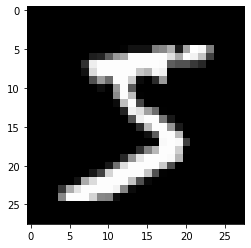

In [2]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

PyTorch uses torch.tensor, rather than numpy arrays, so we need to convert our data.

In [17]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor,
                                         (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


<ipython-input-17-544afca5f442>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(torch.tensor,


# Neural net from scratch(no torch.nn)

Let’s first create a model using nothing but PyTorch tensor operations. We’re assuming you’re already familiar with the basics of neural networks.

PyTorch provides methods to create random or zero-filled tensors, which we will use to create our weights and bias for a simple linear model. These are just regular tensors, with one very special addition: we tell PyTorch that they require a gradient. This causes PyTorch to record all of the operations done on the tensor, so that it can calculate the gradient during back-propagation automatically!

For the weights, we set requires_grad after the initialization, since we don’t want that step included in the gradient. (Note that a trailling _ in PyTorch signifies that the operation is performed in-place.)

In [5]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Thanks to PyTorch’s ability to calculate gradients automatically, we can use any standard Python function (or callable object) as a model! So let’s just write a plain matrix multiplication and broadcasted addition to create a simple linear model. We also need an activation function, so we’ll write log_softmax and use it. Remember: although PyTorch provides lots of pre-written loss functions, activation functions, and so forth, you can easily write your own using plain python. PyTorch will even create fast GPU or vectorized CPU code for your function automatically.

In [11]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb.matmul(weights) + bias)

We will call our function on one batch of data (in this case, 64 images). This is one forward pass. Note that our predictions won’t be any better than random at this stage, since we start with random weights.

In [13]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
print(preds[0], preds.shape)

tensor([-2.1930, -2.7427, -2.8097, -2.8795, -2.8356, -2.1176, -2.3351, -1.7197,
        -2.2648, -1.9047], grad_fn=<SelectBackward>) torch.Size([64, 10])


As you see, the preds tensor contains not only the tensor values, but also a gradient function. We’ll use this later to do backprop.

Let’s implement negative log-likelihood to use as the loss function (again, we can just use standard Python):

In [28]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean() # 负对数似然函数，写法看不懂

loss_func = nll

Let’s check our loss with our random model, so we can see if we improve after a backprop pass later.

In [21]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3456, grad_fn=<NegBackward>)


Let’s also implement a function to calculate the accuracy of our model. For each prediction, if the index with the largest value matches the target value, then the prediction was correct.

In [29]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor(0.0781)


We can now run a training loop. For each iteration, we will:

- select a mini-batch of data (of size bs)
- use the model to make predictions
- calculate the loss
- loss.backward() updates the gradients of the model, in this case, weights and bias.

We now use these gradients to update the weights and bias. We do this within the torch.no_grad() context manager, because we do not want these actions to be recorded for our next calculation of the gradient. You can read more about how PyTorch’s Autograd records operations here.

We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. loss.backward() adds the gradients to whatever is already stored, rather than replacing them).

In [30]:
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

That’s it: we’ve created and trained a minimal neural network (in this case, a logistic regression, since we have no hidden layers) entirely from scratch!

Let’s check the loss and accuracy and compare those to what we got earlier. We expect that the loss will have decreased and accuracy to have increased, and they have.

In [31]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0843, grad_fn=<NegBackward>) tensor(1.)


# Using torch.nn.functional

We will now refactor our code, so that it does the same thing as before, only we’ll start taking advantage of PyTorch’s nn classes to make it more concise and flexible. At each step from here, we should be making our code one or more of: shorter, more understandable, and/or more flexible.

The first and easiest step is to make our code shorter by replacing our hand-written activation and loss functions with those from torch.nn.functional (which is generally imported into the namespace F by convention). This module contains all the functions in the torch.nn library (whereas other parts of the library contain classes). As well as a wide range of loss and activation functions, you’ll also find here some convenient functions for creating neural nets, such as pooling functions. (There are also functions for doing convolutions, linear layers, etc, but as we’ll see, these are usually better handled using other parts of the library.)

If you’re using negative log likelihood loss and log softmax activation, then Pytorch provides a single function F.cross_entropy that combines the two. So we can even remove the activation function from our model.

In [34]:
import torch.nn.functional as F

loss_func = F.cross_entropy


def model(xb):
    return xb.matmul(weights) + bias


print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0843, grad_fn=<NllLossBackward>) tensor(1.)


# Refactor using nn.Module

Next up, we’ll use nn.Module and nn.Parameter, for a clearer and more concise training loop. We subclass nn.Module (which itself is a class and able to keep track of state). In this case, we want to create a class that holds our weights, bias, and method for the forward step. nn.Module has a number of attributes and methods (such as .parameters() and .zero_grad()) which we will be using.

In [36]:
from torch import nn


class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb.matmul(self.weights) + self.bias


model = Mnist_Logistic()

Now we can take advantage of model.parameters() and model.zero_grad() (which are both defined by PyTorch for nn.Module) to make those steps more concise and less prone to the error of forgetting some of our parameters, particularly if we had a more complicated model:

In [39]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()


fit()
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0602, grad_fn=<NllLossBackward>) tensor(1.)


# Refactor using nn.Linear

We continue to refactor our code. Instead of manually defining and initializing self.weights and self.bias, and calculating xb  @ self.weights + self.bias, we will instead use the Pytorch class nn.Linear for a linear layer, which does all that for us. Pytorch has many types of predefined layers that can greatly simplify our code, and often makes it faster too.

In [40]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)


model = Mnist_Logistic()
fit()
print(loss_func(model(xb), yb))

tensor(0.0820, grad_fn=<NllLossBackward>)


# Refactor using optim

Pytorch also has a package with various optimization algorithms, torch.optim. We can use the step method from our optimizer to take a forward step, instead of manually updating each parameter.

In [41]:
from torch import optim

In [42]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)


model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.4770, grad_fn=<NllLossBackward>)
tensor(0.0821, grad_fn=<NllLossBackward>)


# Refactor using Dataset

PyTorch has an abstract Dataset class. A Dataset can be anything that has a __len__ function (called by Python’s standard len function) and a __getitem__ function as a way of indexing into it. This tutorial walks through a nice example of creating a custom FacialLandmarkDataset class as a subclass of Dataset.

PyTorch’s TensorDataset is a Dataset wrapping tensors. By defining a length and way of indexing, this also gives us a way to iterate, index, and slice along the first dimension of a tensor. This will make it easier to access both the independent and dependent variables in the same line as we train.

In [43]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(x_train, y_train)

In [44]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0833, grad_fn=<NllLossBackward>)


# Refactor using Dataloader

Pytorch’s DataLoader is responsible for managing batches. You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches. Rather than having to use train_ds[i\*bs : i\*bs+bs], the DataLoader gives us each minibatch automatically.

In [45]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [46]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0812, grad_fn=<NllLossBackward>)


# Add validation

Shuffling the training data is important to prevent correlation between batches and overfitting. On the other hand, the validation loss will be identical whether we shuffle the validation set or not. Since shuffling takes extra time, it makes no sense to shuffle the validation data.

We’ll use a batch size for the validation set that is twice as large as that for the training set. This is because the validation set does not need backpropagation and thus takes less memory (it doesn’t need to store the gradients). We take advantage of this to use a larger batch size and compute the loss more quickly.

In [47]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [48]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()  # 不开启的话，即使不训练，也会改变权重
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3842)
1 tensor(0.3453)


# Create fit() and get_data()

We’ll now do a little refactoring of our own. Since we go through a similar process twice of calculating the loss for both the training set and the validation set, let’s make that into its own function, loss_batch, which computes the loss for one batch.

We pass an optimizer in for the training set, and use it to perform backprop. For the validation set, we don’t pass an optimizer, so the method doesn’t perform backprop.

In [49]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

fit runs the necessary operations to train our model and compute the training and validation losses for each epoch.

In [50]:
import numpy as np


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

get_data returns dataloaders for the training and validation sets.

In [52]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [53]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3085095314383507
1 0.29188679943084717


# Switch to CNN

We are now going to build our neural network with three convolutional layers. Because none of the functions in the previous section assume anything about the model form, we’ll be able to use them to train a CNN without any modification.

We will use Pytorch’s predefined Conv2d class as our convolutional layer. We define a CNN with 3 convolutional layers. Each convolution is followed by a ReLU. At the end, we perform an average pooling. (Note that view is PyTorch’s version of numpy’s reshape)

In [54]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))


lr = 0.1

Momentum is a variation on stochastic gradient descent that takes previous updates into account as well and generally leads to faster training.

In [55]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3109576334953308
1 0.2897067573428154


# nn.Sequential

torch.nn has another handy class we can use to simply our code: Sequential . A Sequential object runs each of the modules contained within it, in a sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a custom layer from a given function. For instance, PyTorch doesn’t have a view layer, and we need to create one for our network. Lambda will create a layer that we can then use when defining a network with Sequential.

In [56]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [57]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.416130175447464
1 0.2415335572719574


# Wrapping DataLoader

Our CNN is fairly concise, but it only works with MNIST, because:

- It assumes the input is a 28*28 long vector
- It assumes that the final CNN grid size is 4*4 (since that’s the average pooling kernel size we used)

Let’s get rid of these two assumptions, so our model works with any 2d single channel image. First, we can remove the initial Lambda layer but moving the data preprocessing into a generator:

In [58]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Next, we can replace nn.AvgPool2d with nn.AdaptiveAvgPool2d, which allows us to define the size of the output tensor we want, rather than the input tensor we have. As a result, our model will work with any size input.

In [59]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.6057557325839996
1 0.5687076853752137


# Using your GPU

If you’re lucky enough to have access to a CUDA-capable GPU (you can rent one for about $0.50/hour from most cloud providers) you can use it to speed up your code. First check that your GPU is working in Pytorch:

In [60]:
print(torch.cuda.is_available())

True


In [61]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")


def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.5279416006088257
1 0.49581231184005736
